# Factors That Affect Life Expectancy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sqlalchemy import create_engine

from config import usr, pwd, url, port, db, table

%matplotlib inline

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

**Plan:**
Data Cleaning
* What features are categorical?
* What features are continuous?
* Missing values.
    * Interpolate?
    * Remove?
* Outliers.
    * Correct?
    * Transform?
    
Data Exploration
* What features are normally distributed?
* Transform data to make more normal?
* Use Box-Cox transform?
* Standardize variables.
* What variables are correlated with eachother? By how much?
* What variables are correlated with Life Expectancy?
* Narrow feature space by including only variables that are good predictors of life expectancy

Feature Engineering
* Perform PCA on selected features
    * Can Scikit-Learn be used to get eigenvalues?
* Select strongest features to use for predicting Life Expectancy

## Data Cleaning

In [6]:
15*193

2895

In [7]:
np.mean([2000, 2015])

2007.5

In [8]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Country,2938,193,Somalia,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,2938,NaN,NaN,NaN,2007.52,4.61384,2000,2004,2008,2012,2015
Status,2938,2,Developing,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Life expectancy,2928,NaN,NaN,NaN,69.2249,9.52387,36.3,63.1,72.1,75.7,89
Adult Mortality,2928,NaN,NaN,NaN,164.796,124.292,1,74,144,228,723
infant deaths,2938,NaN,NaN,NaN,30.3039,117.927,0,0,3,22,1800
Alcohol,2744,NaN,NaN,NaN,4.60286,4.05241,0.01,0.8775,3.755,7.7025,17.87
percentage expenditure,2938,NaN,NaN,NaN,738.251,1987.91,0,4.68534,64.9129,441.534,19479.9
Hepatitis B,2385,NaN,NaN,NaN,80.9405,25.07,1,77,92,97,99
Measles,2938,NaN,NaN,NaN,2419.59,11467.3,0,0,17,360.25,212183


In [9]:
np.unique(df['Year'])

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015])

### Column Names

In [10]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

**Observation:** Column names contain an extra space.

Remove extra space from column names.

In [11]:
column_map = {x:x.strip() for x in df.columns.tolist()}

In [12]:
column_map

{'Country': 'Country',
 'Year': 'Year',
 'Status': 'Status',
 'Life expectancy ': 'Life expectancy',
 'Adult Mortality': 'Adult Mortality',
 'infant deaths': 'infant deaths',
 'Alcohol': 'Alcohol',
 'percentage expenditure': 'percentage expenditure',
 'Hepatitis B': 'Hepatitis B',
 'Measles ': 'Measles',
 ' BMI ': 'BMI',
 'under-five deaths ': 'under-five deaths',
 'Polio': 'Polio',
 'Total expenditure': 'Total expenditure',
 'Diphtheria ': 'Diphtheria',
 ' HIV/AIDS': 'HIV/AIDS',
 'GDP': 'GDP',
 'Population': 'Population',
 ' thinness  1-19 years': 'thinness  1-19 years',
 ' thinness 5-9 years': 'thinness 5-9 years',
 'Income composition of resources': 'Income composition of resources',
 'Schooling': 'Schooling'}

In [13]:
df = df.rename(columns=column_map).copy()

In [14]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')

In [15]:
all_columns = df.columns.values

In [16]:
catagorical_columns = ['Country', 'Status']
continuous_columns = [x for x in all_columns if x not in catagorical_columns]

### Categorical columns

In [17]:
for column in catagorical_columns:
    print(f'The {column} column has {len(df[column].unique())} unique values.')

The Country column has 193 unique values.
The Status column has 2 unique values.


In [18]:
print(f'The unique values for {catagorical_columns[1]} are {df[catagorical_columns[1]].unique()}.')

The unique values for Status are ['Developing' 'Developed'].


### Missing values

In [19]:
def find_na_columns(df, display_fractions=False):
    na_fractions = (df.isnull().sum()/df.isnull().count())*100
    if display_fractions:
        print(na_fractions)
    return na_fractions[na_fractions != 0]

Categorical columns with missing values:

In [20]:
na_fractions_cat = find_na_columns(df.loc[:, catagorical_columns])

In [21]:
na_fractions_cat

Series([], dtype: float64)

**Observation:** No catagorical columns are missing values.

In [22]:
na_fractions_con = find_na_columns(df.loc[:, continuous_columns])

In [23]:
print(na_fractions_con)

Life expectancy                     0.340368
Adult Mortality                     0.340368
Alcohol                             6.603131
Hepatitis B                        18.822328
BMI                                 1.157250
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: float64


Plan
* Loop over countries
* Sort by year
* Interpolate values

In [24]:
def interpolate_over_categories(df, category, sort_by=None):
    category_list = np.unique(df[category])
    
    category_df_list = []
    for value in category_list:
        df_cat = df.loc[df[category] == value, :].copy()
        if sort_by is not None:
            df_cat.sort_values(by=sort_by, inplace=True)
    
        na_fractions = find_na_columns(df_cat.loc[df_cat[category] == value, :])
        for column in na_fractions.index.tolist():
            
            if na_fractions[column] != 100.0:
                df_cat.loc[df_cat[category] == value,
                           column] = df_cat.loc[df_cat[category] == value,
                                                column].interpolate()
    
        category_df_list.append(df_cat)
        
    df_interpolated = pd.concat(category_df_list)
    df_interpolated.index = np.arange(len(df_interpolated))
    
    return df_interpolated

In [25]:
df_clean = interpolate_over_categories(df, 'Country', 'Year')

In [26]:
print(find_na_columns(df_clean.loc[:, continuous_columns]))

Life expectancy                     0.340368
Adult Mortality                     0.340368
Alcohol                             0.578625
Hepatitis B                        18.822328
BMI                                 1.157250
Polio                               0.646698
Total expenditure                   1.599728
Diphtheria                          0.646698
GDP                                14.669843
Population                         22.055820
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: float64


**Observation:**

In [27]:
many_missing_values = ['Hepatitis B', 'GDP', 'Population']
print(f'There is a large number of missing values for {many_missing_values}.')

There is a large number of missing values for ['Hepatitis B', 'GDP', 'Population'].


I will drop these columns and use the other columns as features in this dataset.

In [28]:
df_clean = df_clean.drop(columns=many_missing_values).copy()

Since the other values only have a small number of missing values, I will remove all columns with missing values.

In [29]:
df_clean = df_clean.dropna(how='any').copy()
df_clean.index = np.arange(len(df_clean))

In [30]:
print(f'{(len(df) - len(df_clean)) / len(df):0.3f} fraction of the data was removed from the orignal dataset.')

0.072 fraction of the data was removed from the orignal dataset.


In [31]:
# Update continous columns list
continuous_columns = [x for x in continuous_columns if x not in many_missing_values]

## Outliers

In [32]:
def log_transform(df, column_list):
    for column in column_list:
        df[f'log_{column}'] = np.log(df[column] + 1)
    return df

In [33]:
def boxcox_transform(df, column_list):
    for column in column_list:
        boxcox_transform, _ = boxcox(df[column] + 1)
        df[f'boxcox_{column}'] = boxcox_transform
    return df

In [34]:
thresholds = {
    'tukey': 1.5
}

In [35]:
def apply_tukey(df, column, thresh=1.5):
    q75, q25 = np.percentile(df[column], [75, 25])
    iqr = q75 - q25
    min_value = q25 - thresh*iqr
    max_value = q75 + thresh*iqr
    df[f'tukey_{column}'] = df[column].apply(lambda x: np.min([x, max_value]))
    df[f'tukey_{column}'] = df[f'tukey_{column}'].apply(lambda x: np.max([x, min_value]))
    return df

In [36]:
def correct_outliers(df, column_list):
    for column in column_list:
        # Tukey
        df = apply_tukey(df, column, thresh=thresholds['tukey'])
        
    return df

In [37]:
def stack_dataframe(df, column_list):
    df_stacked = df.loc[:, column_list].stack().copy()
    df_stacked.index = df_stacked.index.droplevel()
    df_stacked = df_stacked.reset_index().copy()
    df_stacked = df_stacked.rename(columns={'index': 'label', 0: 'value'})
    df_stacked = df_stacked.sort_values(by='label')
    df_stacked.index = np.arange(len(df_stacked))
    return df_stacked

In [38]:
def look_for_outliers(df, column_list):
    
    if len(column_list) > 1:
        df_stacked = stack_dataframe(df, column_list)
        sns.catplot(x='label', y='value', data=df_stacked, height=4, aspect=12/6, kind='box')
        plt.show()
    else:
        sns.catplot(y=column_list[0], data=df, height=4, aspect=12/6, kind='box')
        plt.show()

In [39]:
continuous_columns[1:]

['Life expectancy',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Measles',
 'BMI',
 'under-five deaths',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'thinness  1-19 years',
 'thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

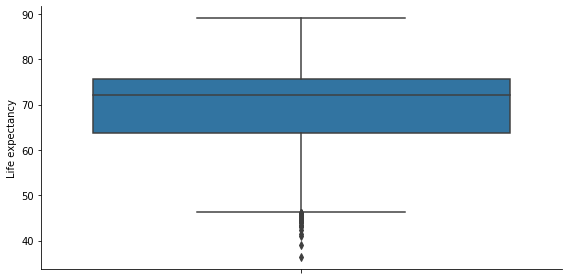

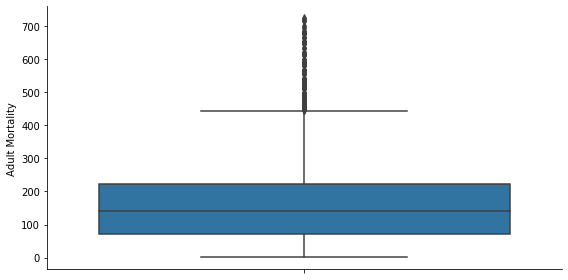

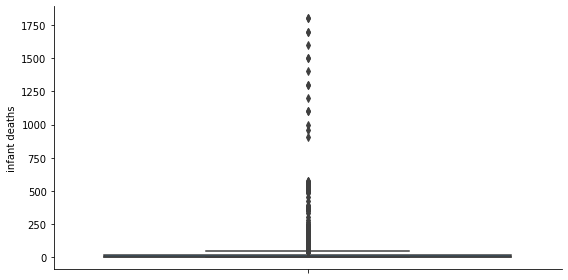

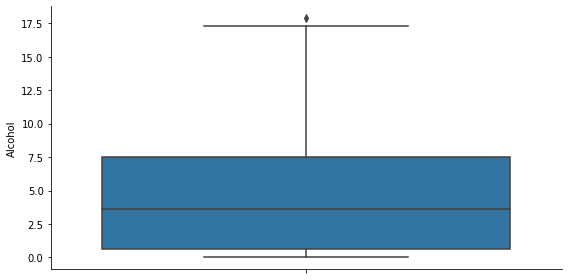

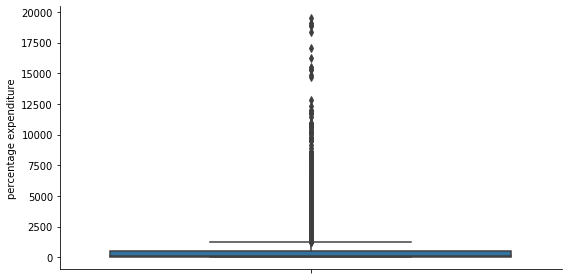

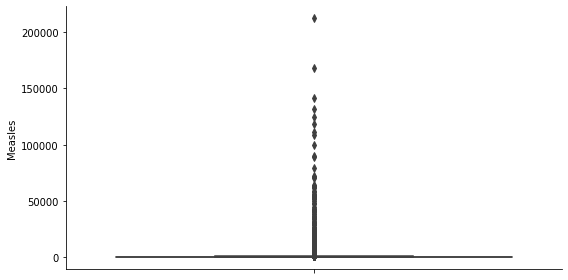

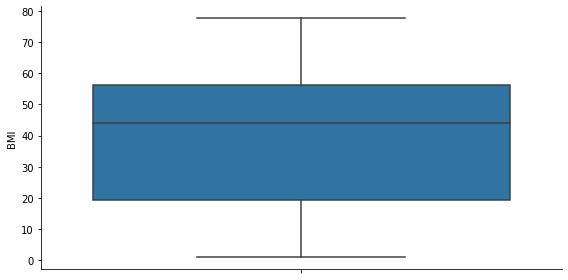

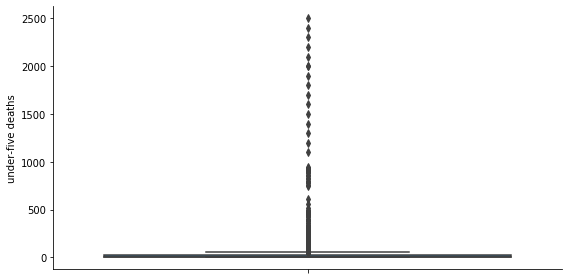

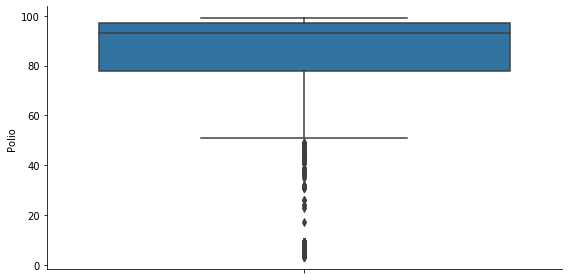

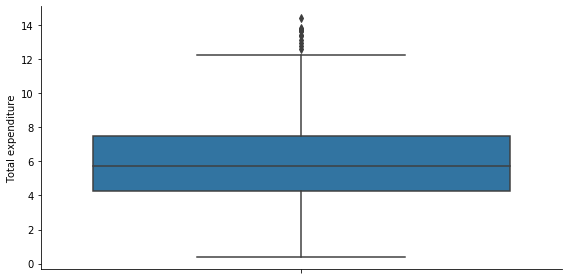

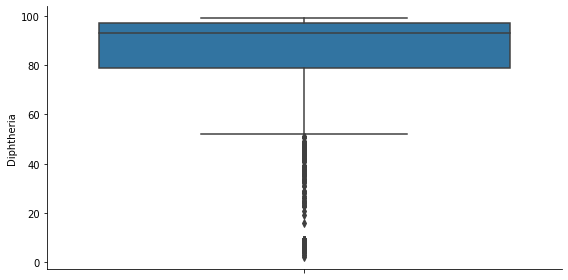

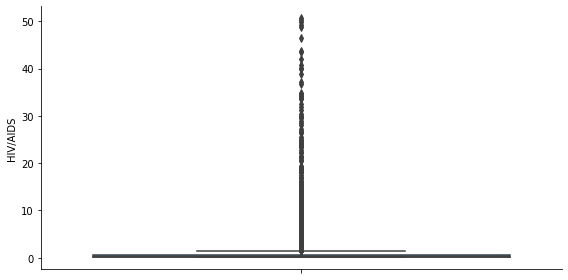

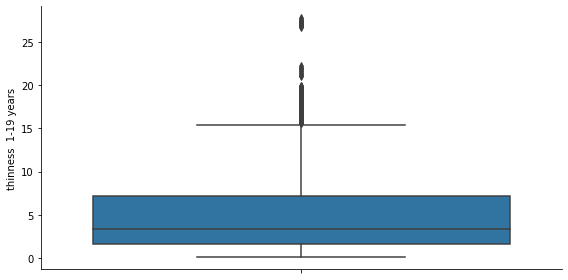

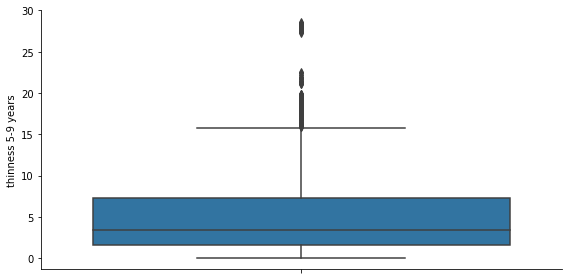

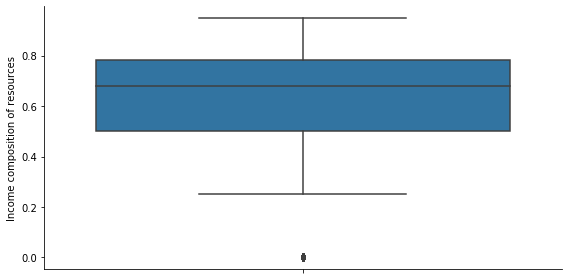

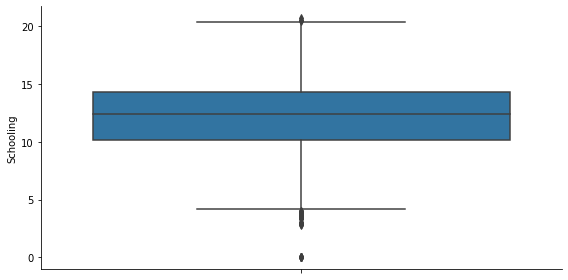

In [40]:
for column in continuous_columns[1:]:
    look_for_outliers(df_clean, [column])

### Log transform
Try log transformations to remove outliers and correct for normality.

In [41]:
columns_to_log_transform = ['Adult Mortality', 'infant deaths', 'percentage expenditure', 'Measles',
                            'under-five deaths', 'Polio', 'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
                            'thinness 5-9 years']

In [42]:
df_clean = log_transform(df_clean, columns_to_log_transform)

In [43]:
log_columns = [f'log_{x}' for x in columns_to_log_transform]

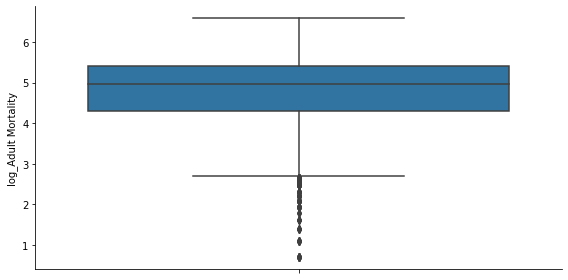

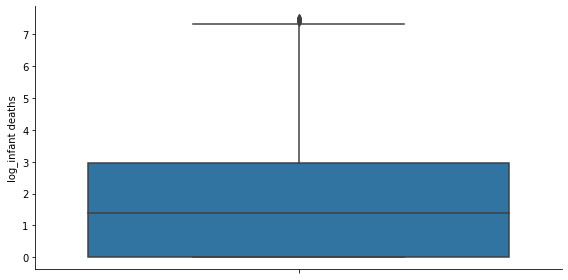

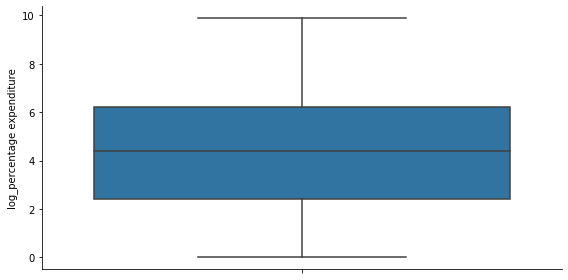

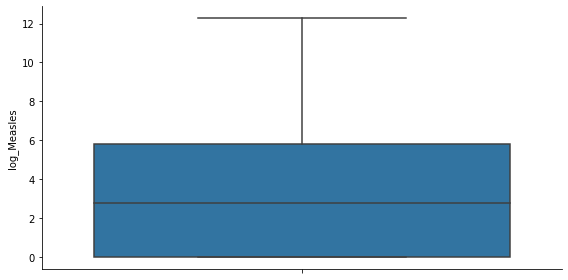

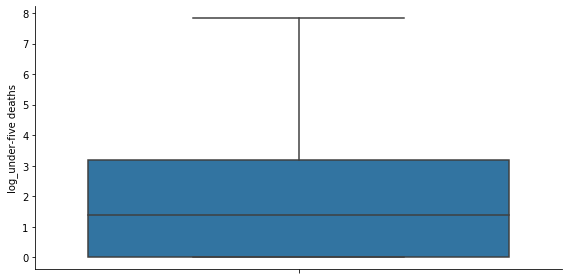

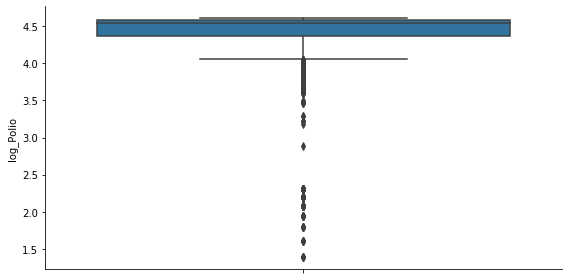

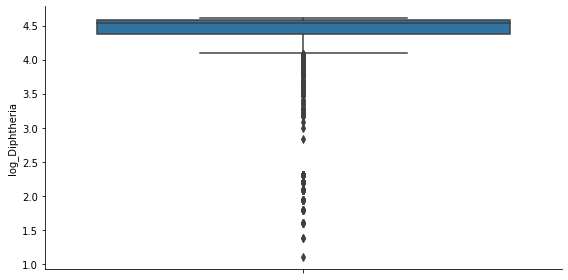

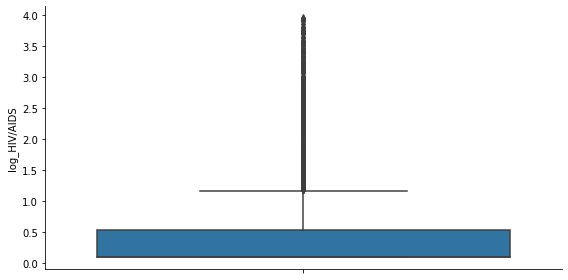

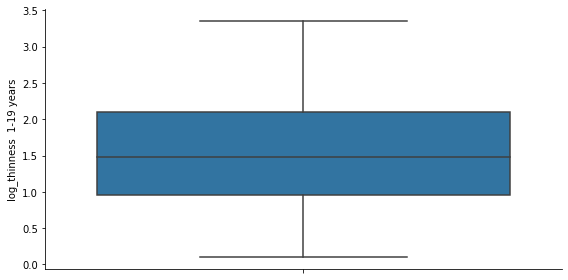

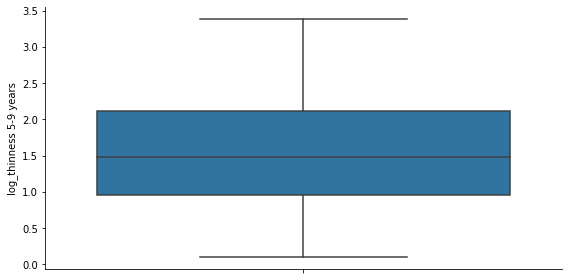

In [44]:
for column in log_columns:
    look_for_outliers(df_clean, [column])

### Box-Cox Transformation
Try Box-Cox transformations to remove outliers and correct for normality.

In [45]:
columns_to_boxcox_transform = ['Life expectancy', 'Adult Mortality', 'infant deaths', 'percentage expenditure', 'Measles',
                               'under-five deaths', 'Polio', 'Diphtheria', 'HIV/AIDS', 'thinness  1-19 years',
                               'thinness 5-9 years', 'Alcohol']

In [46]:
df_clean = boxcox_transform(df_clean, columns_to_boxcox_transform)

In [47]:
boxcox_columns = [f'boxcox_{x}' for x in columns_to_boxcox_transform]

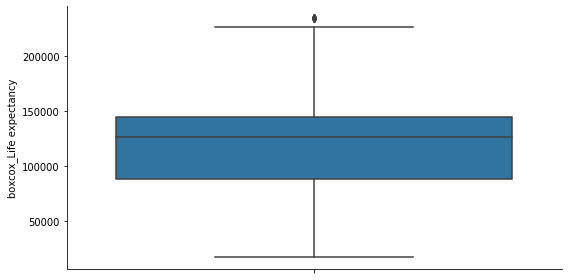

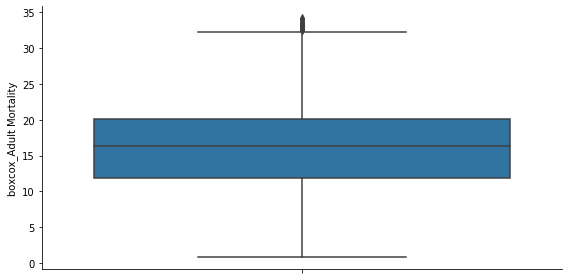

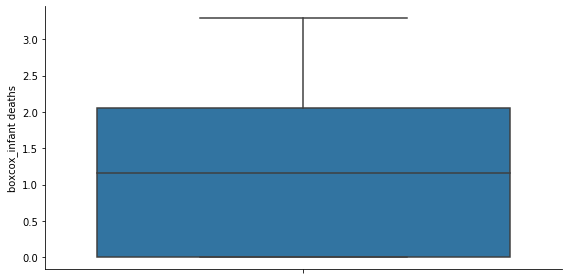

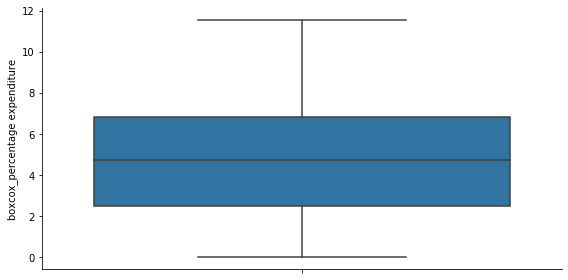

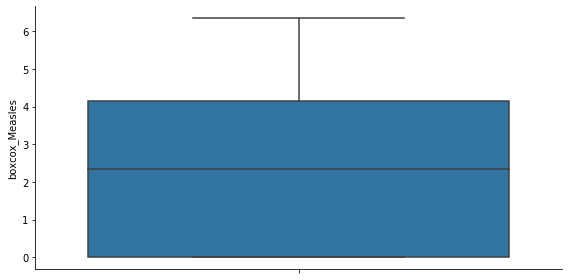

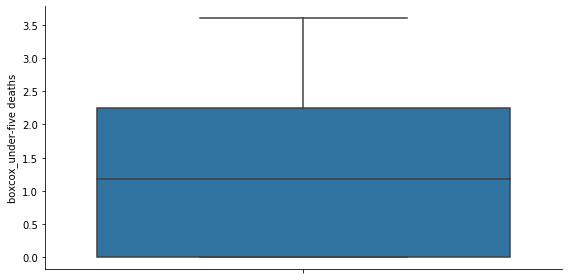

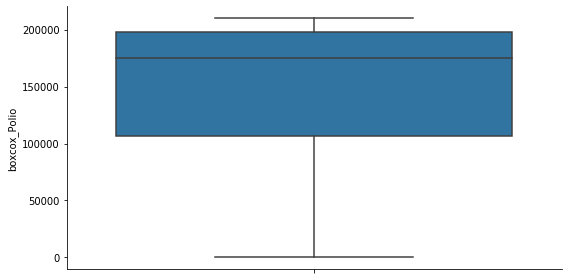

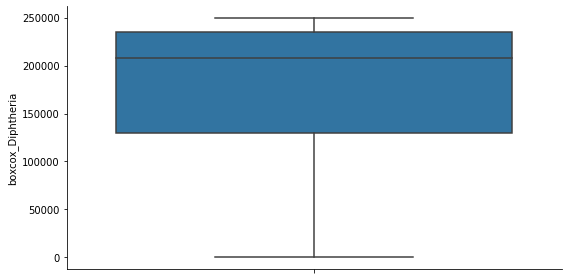

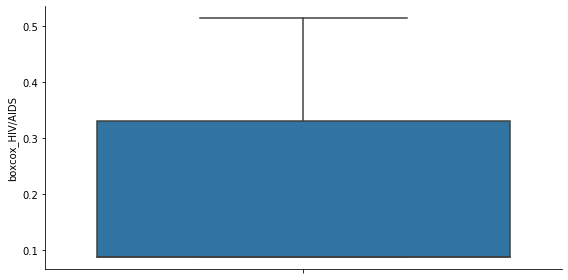

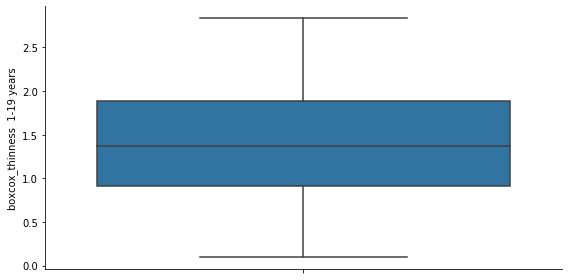

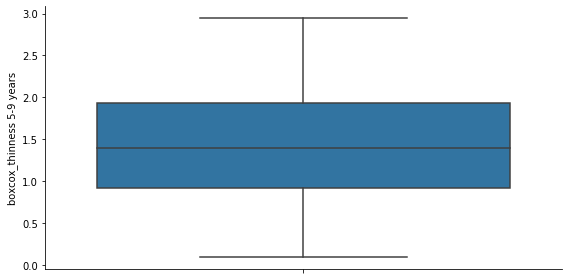

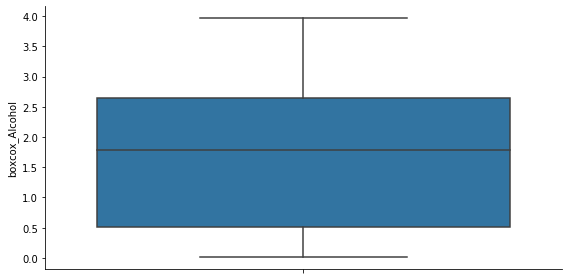

In [48]:
for column in boxcox_columns:
    look_for_outliers(df_clean, [column])

**Observation:** BoxCox does a better job dealing with the highly skewed data than log transformation.

### Correct outliers
Use the Tukey method to correct for additional outliers seen in the data.

In [49]:
columns_to_apply_tukey = ['Life expectancy', 'Total expenditure', 'Income composition of resources', 'Schooling',
                          'boxcox_Adult Mortality']

In [50]:
df_clean = correct_outliers(df_clean, columns_to_apply_tukey)

In [51]:
tukey_columns = [f'tukey_{x}' for x in columns_to_apply_tukey]

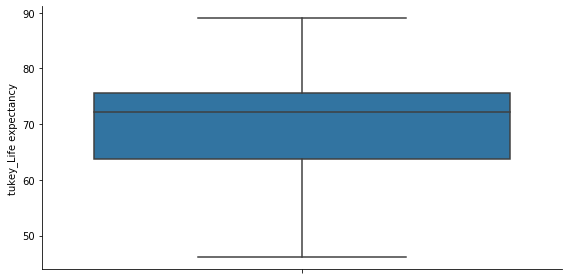

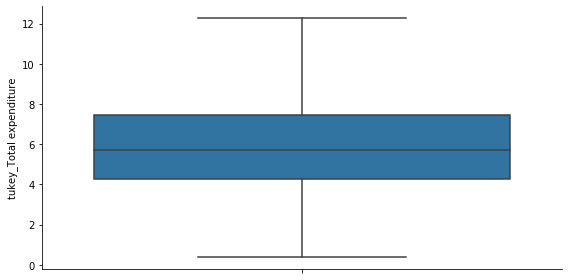

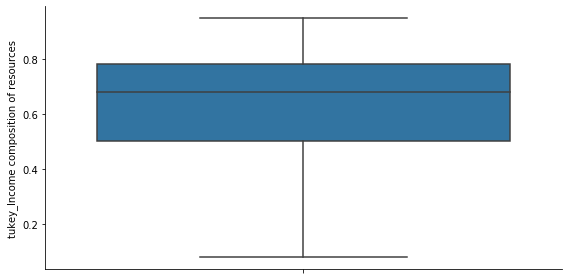

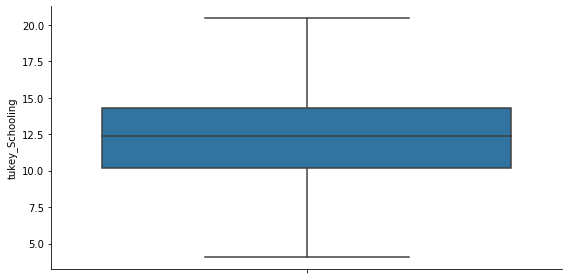

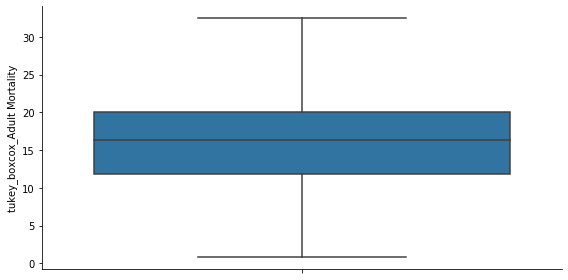

In [52]:
for column in tukey_columns:
    look_for_outliers(df_clean, [column])

In [53]:
df_clean.columns

Index(['Country', 'Year', 'Status', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Measles', 'BMI',
       'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
       'HIV/AIDS', 'thinness  1-19 years', 'thinness 5-9 years',
       'Income composition of resources', 'Schooling', 'log_Adult Mortality',
       'log_infant deaths', 'log_percentage expenditure', 'log_Measles',
       'log_under-five deaths', 'log_Polio', 'log_Diphtheria', 'log_HIV/AIDS',
       'log_thinness  1-19 years', 'log_thinness 5-9 years',
       'boxcox_Life expectancy', 'boxcox_Adult Mortality',
       'boxcox_infant deaths', 'boxcox_percentage expenditure',
       'boxcox_Measles', 'boxcox_under-five deaths', 'boxcox_Polio',
       'boxcox_Diphtheria', 'boxcox_HIV/AIDS', 'boxcox_thinness  1-19 years',
       'boxcox_thinness 5-9 years', 'boxcox_Alcohol', 'tukey_Life expectancy',
       'tukey_Total expenditure', 'tukey_Income composition of resourc

Select columns to use for further analysis. Only include variables with few outliers and appearing most normal.

In [54]:
columns_subset = ['Country', 'Year', 'Status', 'BMI', 'boxcox_Alcohol', 'boxcox_infant deaths',
                  'boxcox_percentage expenditure', 'boxcox_Measles', 'boxcox_under-five deaths', 'boxcox_Polio', 
                  'boxcox_Diphtheria', 'boxcox_HIV/AIDS', 'boxcox_thinness  1-19 years', 'boxcox_thinness 5-9 years', 
                  'tukey_Life expectancy', 'tukey_Total expenditure', 'tukey_Income composition of resources',
                  'tukey_Schooling', 'tukey_boxcox_Adult Mortality']

In [55]:
df_subset = df_clean.loc[:, columns_subset]

## Standardize dataset

In [56]:
columns_to_standardize = ['BMI', 'boxcox_Alcohol', 'boxcox_infant deaths', 'boxcox_percentage expenditure', 
                          'boxcox_Measles', 'boxcox_under-five deaths', 'boxcox_Polio', 'boxcox_Diphtheria', 
                          'boxcox_HIV/AIDS', 'boxcox_thinness  1-19 years', 'boxcox_thinness 5-9 years', 
                          'tukey_Life expectancy', 'tukey_Total expenditure', 'tukey_Income composition of resources',
                          'tukey_Schooling', 'tukey_boxcox_Adult Mortality']

In [57]:
df_standardized = pd.DataFrame(StandardScaler().fit_transform(df_subset.loc[:, columns_to_standardize]), 
                               columns=columns_to_standardize)
columns_to_add_back = ['Country', 'Year', 'Status']
for column in columns_to_add_back:
    df_standardized[column] = df_subset[column].values

In [58]:
df_standardized.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,2725.0,1.538423e-16,1.000184,-1.890303,-0.963175,0.271317,0.886044,1.969374
boxcox_Alcohol,2725.0,1.564498e-17,1.000184,-1.448061,-1.006128,0.115645,0.875360,2.026883
boxcox_infant deaths,2725.0,-5.866867e-17,1.000184,-1.198790,-1.198790,-0.001469,0.916061,2.186640
boxcox_percentage expenditure,2725.0,1.042999e-17,1.000184,-1.562651,-0.718139,0.019572,0.729690,2.311597
boxcox_Measles,2725.0,1.147298e-16,1.000184,-1.119683,-1.119683,0.030866,0.911973,1.985770
boxcox_under-five deaths,2725.0,0.000000e+00,1.000184,-1.226109,-1.226109,-0.106175,0.896185,2.175165
boxcox_Polio,2725.0,1.238561e-16,1.000184,-2.309034,-0.648531,0.436266,0.787873,0.974197
boxcox_Diphtheria,2725.0,5.214993e-18,1.000184,-2.306238,-0.598036,0.434691,0.790917,0.979921
boxcox_HIV/AIDS,2725.0,2.294597e-16,1.000184,-0.693770,-0.693770,-0.693770,0.809008,1.935057
boxcox_thinness 1-19 years,2725.0,-2.555346e-16,1.000184,-2.114063,-0.774340,-0.012170,0.837420,2.388959


### Correlations

In [59]:
df_standardized.loc[:, columns_to_standardize].corr()

,BMI,boxcox_Alcohol,boxcox_infant deaths,boxcox_percentage expenditure,boxcox_Measles,boxcox_under-five deaths,boxcox_Polio,boxcox_Diphtheria,boxcox_HIV/AIDS,boxcox_thinness 1-19 years,boxcox_thinness 5-9 years,tukey_Life expectancy,tukey_Total expenditure,tukey_Income composition of resources,tukey_Schooling,tukey_boxcox_Adult Mortality
BMI,1.000000,0.302452,-0.468118,0.270269,-0.300027,-0.482011,0.338247,0.335462,-0.502723,-0.551084,-0.564553,0.566119,0.216339,0.535316,0.576403,-0.337204
boxcox_Alcohol,0.302452,1.000000,-0.380683,0.360322,-0.220976,-0.378535,0.246768,0.249805,-0.156757,-0.451430,-0.443607,0.354466,0.305198,0.422644,0.514903,-0.151048
boxcox_infant deaths,-0.468118,-0.380683,1.000000,-0.339953,0.569135,0.993917,-0.426029,-0.409901,0.451126,0.467724,0.482526,-0.589722,-0.209963,-0.468485,-0.577615,0.342236
boxcox_percentage expenditure,0.270269,0.360322,-0.339953,1.000000,-0.118971,-0.344562,0.227812,0.226145,-0.234957,-0.329899,-0.341102,0.408634,0.153891,0.417243,0.448306,-0.265356
boxcox_Measles,-0.300027,-0.220976,0.569135,-0.118971,1.000000,0.570766,-0.268704,-0.278449,0.213703,0.330832,0.343973,-0.307510,-0.165971,-0.212261,-0.297711,0.136315
boxcox_under-five deaths,-0.482011,-0.378535,0.993917,-0.344562,0.570766,1.000000,-0.433512,-0.417684,0.479464,0.475611,0.489755,-0.612299,-0.213759,-0.481151,-0.591628,0.356684
boxcox_Polio,0.338247,0.246768,-0.426029,0.227812,-0.268704,-0.433512,1.000000,0.866996,-0.479503,-0.233890,-0.239477,0.564635,0.158585,0.488700,0.521874,-0.281935
boxcox_Diphtheria,0.335462,0.249805,-0.409901,0.226145,-0.278449,-0.417684,0.866996,1.000000,-0.476305,-0.235357,-0.238509,0.567146,0.162398,0.499512,0.528134,-0.275799
boxcox_HIV/AIDS,-0.502723,-0.156757,0.451126,-0.234957,0.213703,0.479464,-0.479503,-0.476305,1.000000,0.428951,0.414002,-0.801566,-0.099230,-0.574006,-0.606576,0.490736
boxcox_thinness 1-19 years,-0.551084,-0.451430,0.467724,-0.329899,0.330832,0.475611,-0.233890,-0.235357,0.428951,1.000000,0.950931,-0.543315,-0.319450,-0.489989,-0.548702,0.314512


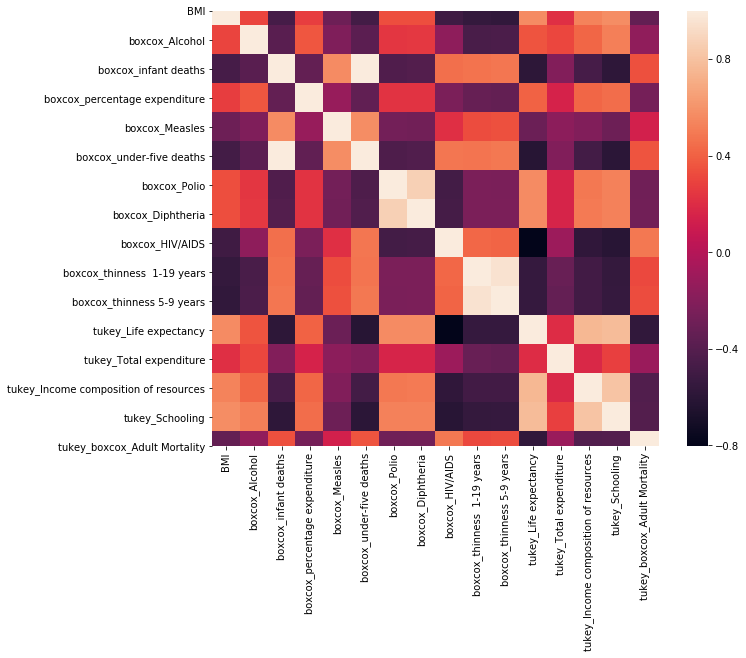

In [60]:
f, axes = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_standardized.loc[:, columns_to_standardize].corr(), ax=axes)
plt.show()

In [61]:
df_standardized.loc[:, columns_to_standardize].corr()['tukey_Life expectancy'].sort_values()

boxcox_HIV/AIDS                         -0.801566
boxcox_under-five deaths                -0.612299
boxcox_infant deaths                    -0.589722
tukey_boxcox_Adult Mortality            -0.567259
boxcox_thinness 5-9 years               -0.547670
boxcox_thinness  1-19 years             -0.543315
boxcox_Measles                          -0.307510
tukey_Total expenditure                  0.204202
boxcox_Alcohol                           0.354466
boxcox_percentage expenditure            0.408634
boxcox_Polio                             0.564635
BMI                                      0.566119
boxcox_Diphtheria                        0.567146
tukey_Income composition of resources    0.756760
tukey_Schooling                          0.776240
tukey_Life expectancy                    1.000000
Name: tukey_Life expectancy, dtype: float64

In [62]:
life_expectancy_feature_correlations = df_standardized.loc[:, 
                                                           columns_to_standardize].corr()['tukey_Life expectancy'].sort_values()

In [63]:
trimmed_features = life_expectancy_feature_correlations[(life_expectancy_feature_correlations > 0.6) |
                                                        (life_expectancy_feature_correlations < -0.6)]

In [64]:
trimmed_features.index.tolist()

['boxcox_HIV/AIDS',
 'boxcox_under-five deaths',
 'tukey_Income composition of resources',
 'tukey_Schooling',
 'tukey_Life expectancy']

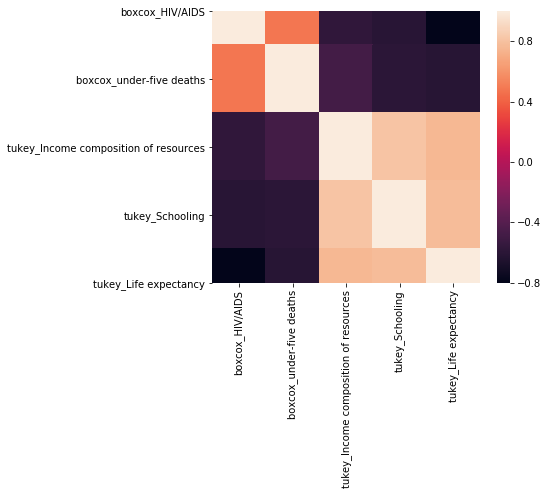

In [65]:
f, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(df_standardized.loc[:, trimmed_features.index.tolist()].corr(), ax=axes)
plt.show()

In [66]:
df_model = df_standardized.loc[:, trimmed_features.index.tolist()].copy()

### PCA
After narrowing the feature space, let's see if PCA can further reduce the number of features

In [67]:
feature_list = ['boxcox_HIV/AIDS', 'boxcox_under-five deaths', 'tukey_Income composition of resources',
                'tukey_Schooling']

X = df_model.loc[:, feature_list]

sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X)

In [68]:
variance_explained = sklearn_pca.explained_variance_ratio_
print(variance_explained)

[0.69640521 0.14011985 0.11950773 0.04396721]


In [69]:
print(f'The first component explains {variance_explained[0]:0.3f} fraction of the variance.')

The first component explains 0.696 fraction of the variance.


In [70]:
two_components_sum = variance_explained[0] + variance_explained[1]
print(f'The first two components explain {two_components_sum:0.3f} fraction of the variance.')

The first two components explain 0.837 fraction of the variance.


In [71]:
three_components_sum = two_components_sum + variance_explained[2]
print(f'The first three components explain {three_components_sum:0.3f} fraction of the variance.')

The first three components explain 0.956 fraction of the variance.


Reducing the feature space to three components can explain 96% of the variance.

In [72]:
df_model['first_component'] = Y_sklearn[:, 0]
df_model['second_component'] = Y_sklearn[:, 1]
df_model['third_component'] = Y_sklearn[:, 2]

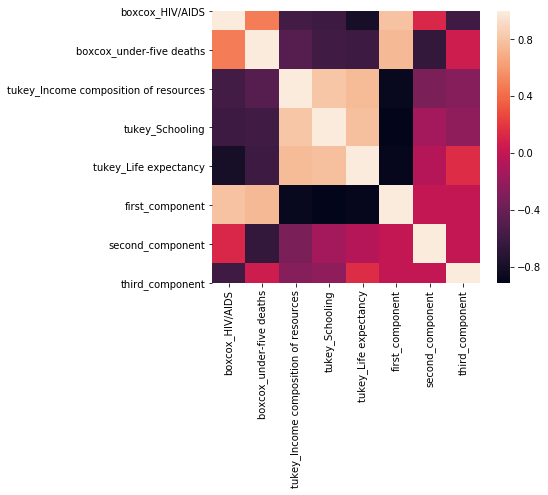

In [73]:
f, axes = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(df_model.corr(), ax=axes)
plt.show()

In [74]:
df_model.corr()['tukey_Life expectancy'].sort_values()

first_component                         -0.884357
boxcox_HIV/AIDS                         -0.801566
boxcox_under-five deaths                -0.612299
second_component                        -0.066962
third_component                          0.154854
tukey_Income composition of resources    0.756760
tukey_Schooling                          0.776240
tukey_Life expectancy                    1.000000
Name: tukey_Life expectancy, dtype: float64

## Conclusions
The variables most related, correlated, with Life Expectancy are: HIV/AIDS, under-five deaths, Income composition of resources, and Schooling. The feature space can be reduced to three components using PCA, which together explain 96% of the variance.